# Binary Prediction of Smoker Status using Bio-Signals

__Aim__: predict a patient's smoking status given information about various other health indicators.

__Link to the competition__: [\<click!\>](https://www.kaggle.com/competitions/playground-series-s3e24)

__Score__: AUC = 0.873

___

### APPROACH
The approach of this work can be described as follows:
1. brief EDA
2. apply feature engineering (adding features, dropping features, clustering with the different groups of features)
3. evaluate the basic models
4. create the ensembles of best-performing basic models (2-4 basic models in one ensemble)
5. evaluate such ensembles and find out the one that performs best

___

### IMPORTS

In [3]:
# main modules
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import itertools

In [4]:
# modules used in data processing
from sklearn.model_selection import GridSearchCV, StratifiedKFold, train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import FunctionTransformer, PolynomialFeatures, StandardScaler
from sklearn.kernel_approximation import Nystroem
from sklearn.metrics import roc_auc_score
from sklearn.cluster import KMeans

In [5]:
# classifiers
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, HistGradientBoostingClassifier, AdaBoostClassifier, VotingClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

___

### LOAD TRAIN DATAFRAME

In [6]:
train = pd.read_csv('train.csv', index_col='id').reset_index(drop=True)
train

,age,height(cm),weight(kg),waist(cm),eyesight(left),eyesight(right),hearing(left),hearing(right),systolic,relaxation,...,HDL,LDL,hemoglobin,Urine protein,serum creatinine,AST,ALT,Gtp,dental caries,smoking
0,55,165,60,81.0,0.5,0.6,1,1,135,87,...,40,75,16.5,1,1.0,22,25,27,0,1
1,70,165,65,89.0,0.6,0.7,2,2,146,83,...,57,126,16.2,1,1.1,27,23,37,1,0
2,20,170,75,81.0,0.4,0.5,1,1,118,75,...,45,93,17.4,1,0.8,27,31,53,0,1
3,35,180,95,105.0,1.5,1.2,1,1,131,88,...,38,102,15.9,1,1.0,20,27,30,1,0
4,30,165,60,80.5,1.5,1.0,1,1,121,76,...,44,93,15.4,1,0.8,19,13,17,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
159251,40,155,45,69.0,1.5,2.0,1,1,127,80,...,72,159,14.5,1,0.8,25,26,13,0,0
159252,50,155,75,82.0,1.0,1.0,1,1,120,80,...,64,108,14.5,1,0.6,21,20,18,0,0
159253,40,160,50,66.0,1.5,1.0,1,1,114,70,...,87,93,10.9,1,0.6,15,9,12,0,0
159254,50,165,75,92.0,1.2,1.0,1,1,121,90,...,55,80,14.4,1,1.1,22,17,37,0,1


In [7]:
# df doesn't have missing values
train.notna().all().all()

True

In [6]:
# df doesn't have duplicated rows
train.duplicated().any()

False

___

### RENAME FEATURES

In [7]:
train.columns

Index(['age', 'height(cm)', 'weight(kg)', 'waist(cm)', 'eyesight(left)',
       'eyesight(right)', 'hearing(left)', 'hearing(right)', 'systolic',
       'relaxation', 'fasting blood sugar', 'Cholesterol', 'triglyceride',
       'HDL', 'LDL', 'hemoglobin', 'Urine protein', 'serum creatinine', 'AST',
       'ALT', 'Gtp', 'dental caries', 'smoking'],
      dtype='object')

In [8]:
def rename_columns(df):
    """Func renames features"""
    colnames = {
        'height(cm)': 'height',
        'weight(kg)': 'weight',
        'waist(cm)': 'waist',
        'eyesight(left)': 'eyesight_l',
        'eyesight(right)': 'eyesight_r',
        'hearing(left)': 'hearing_l',
        'hearing(right)': 'hearing_r',
        'fasting blood sugar': 'blood_sugar',
        'Cholesterol': 'cholesterol',
        'Urine protein': 'urine_protein',
        'serum creatinine': 'serum_creatinine',
        'Gtp': 'GTP',
        'dental caries': 'dental_caries'
    }
    return df.rename(columns=colnames)

In [9]:
train = rename_columns(train)
train.columns

Index(['age', 'height', 'weight', 'waist', 'eyesight_l', 'eyesight_r',
       'hearing_l', 'hearing_r', 'systolic', 'relaxation', 'blood_sugar',
       'cholesterol', 'triglyceride', 'HDL', 'LDL', 'hemoglobin',
       'urine_protein', 'serum_creatinine', 'AST', 'ALT', 'GTP',
       'dental_caries', 'smoking'],
      dtype='object')

__!! RECALL__: call __rename_columns()__ on a test dataframe.

___

### BASE SCORE

In [12]:
# create a df called log_df that will store scoring for different transforms of a train df
log_df = pd.DataFrame(columns=['label', 
                               'train_score', 
                               'test_score'])

In [13]:
def evaluate_transformation(df, func, label):
    """Func evaluates an impact of a transform"""
    df = func(df)
    tree = RandomForestClassifier(max_depth=10, random_state=1)
    X = df.drop('smoking', axis=1)
    y = df.smoking
    X_train, X_test, y_train, y_test = train_test_split(X, 
                                                        y, 
                                                        test_size=0.3, 
                                                        random_state=1)
    tree.fit(X_train, y_train)
    train_score = roc_auc_score(y_true=y_train, 
                                y_score=tree.predict(X_train))
    test_score = roc_auc_score(y_true=y_test, 
                               y_score=tree.predict(X_test))
    global log_df
    log_df = pd.concat([log_df, 
                        pd.DataFrame({
                            'label': [label], 
                            'train_score': [train_score], 
                            'test_score': [test_score]})], 
                       axis=0, 
                       ignore_index=True)

In [14]:
# evaluate initial df with no additional transforms applied
evaluate_transformation(df=train, 
                        func=lambda df: df, 
                        label='initial df')
log_df

,label,train_score,test_score
0,initial df,0.801774,0.780065


<!-- __!! RECALL__: call __one_hot_features()__ on a test dataframe. -->
...

___

### OUTLIERS

In [15]:
# define the names of numeric features
numeric_features = [col for col in train.columns
                    if not ((train[col] == 0) | (train[col] == 1)).all()]
len(numeric_features)

21

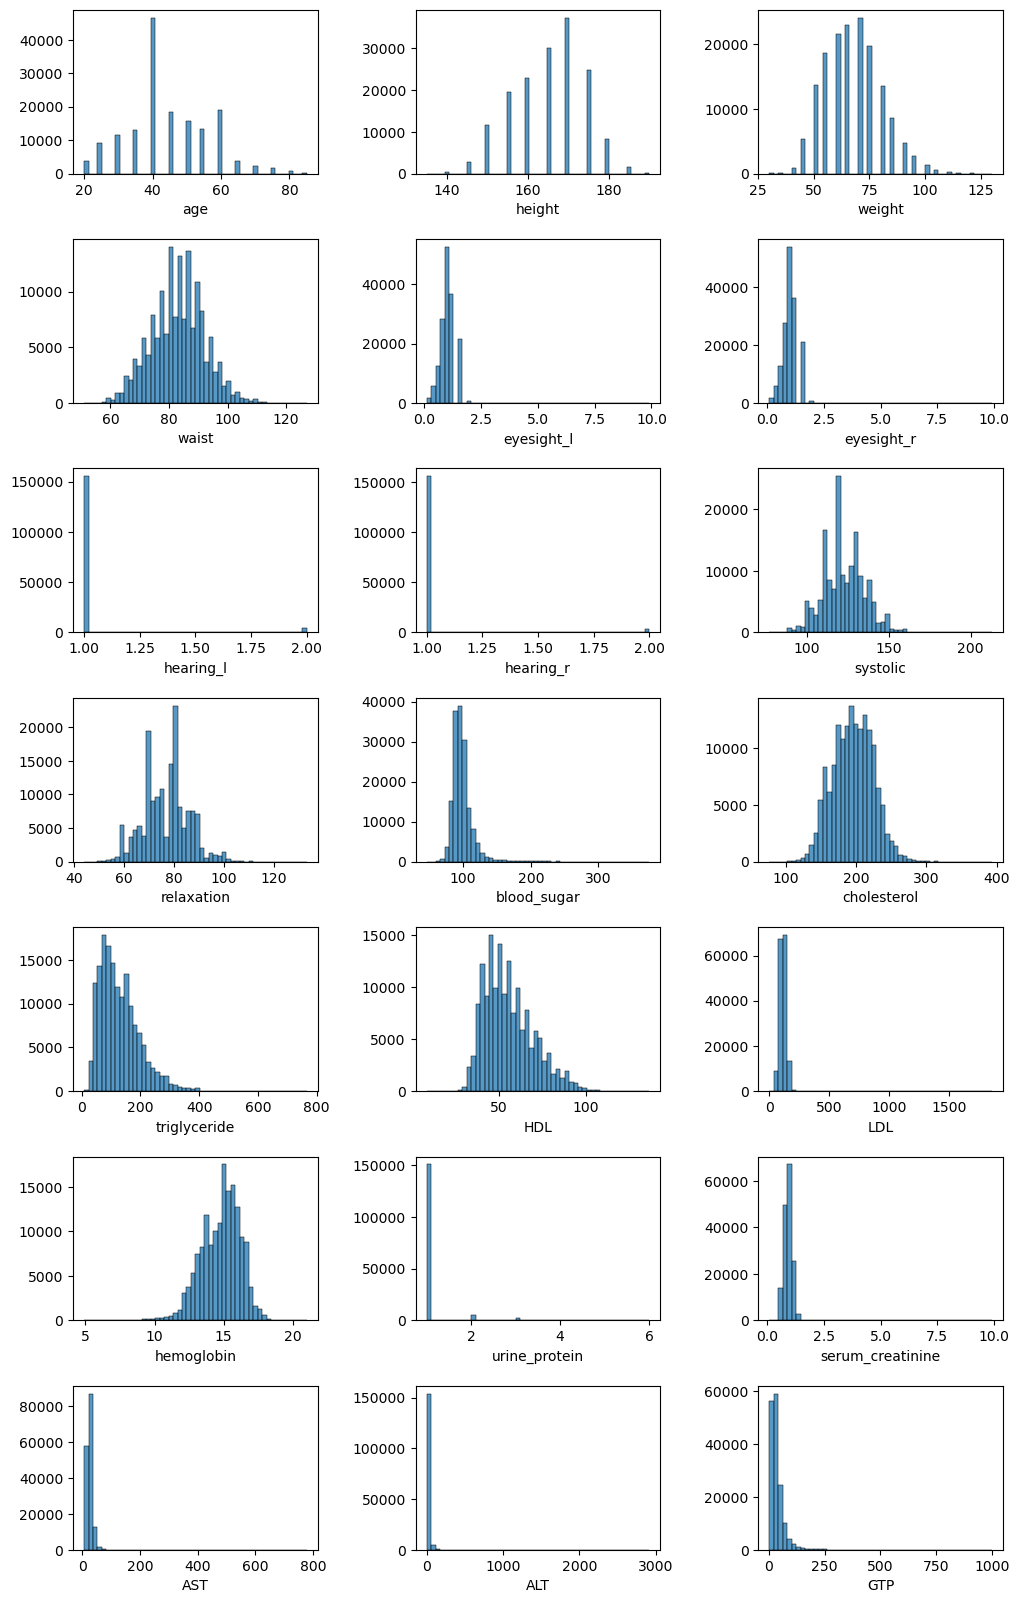

In [16]:
# plot distributions of each numeric feature
fig, axs = plt.subplots(nrows=7, 
                        ncols=3, 
                        figsize=(12, 20))
for feature, ax in zip(numeric_features, axs.ravel()):
    sns.histplot(data=train, 
                 x=feature, 
                 ax=ax, 
                 bins=50)
    ax.set(ylabel='')
plt.subplots_adjust(wspace=.4, hspace=.4)

In [17]:
# prepare a dict to store outliers thresholds
outliers_values = dict.fromkeys(['blood_sugar', 
                                 'cholesterol', 
                                 'triglyceride', 
                                 'HDL', 
                                 'LDL', 
                                 'serum_creatinine', 
                                 'AST', 
                                 'ALT', 
                                 'GTP'])

In [18]:
len(outliers_values)

9

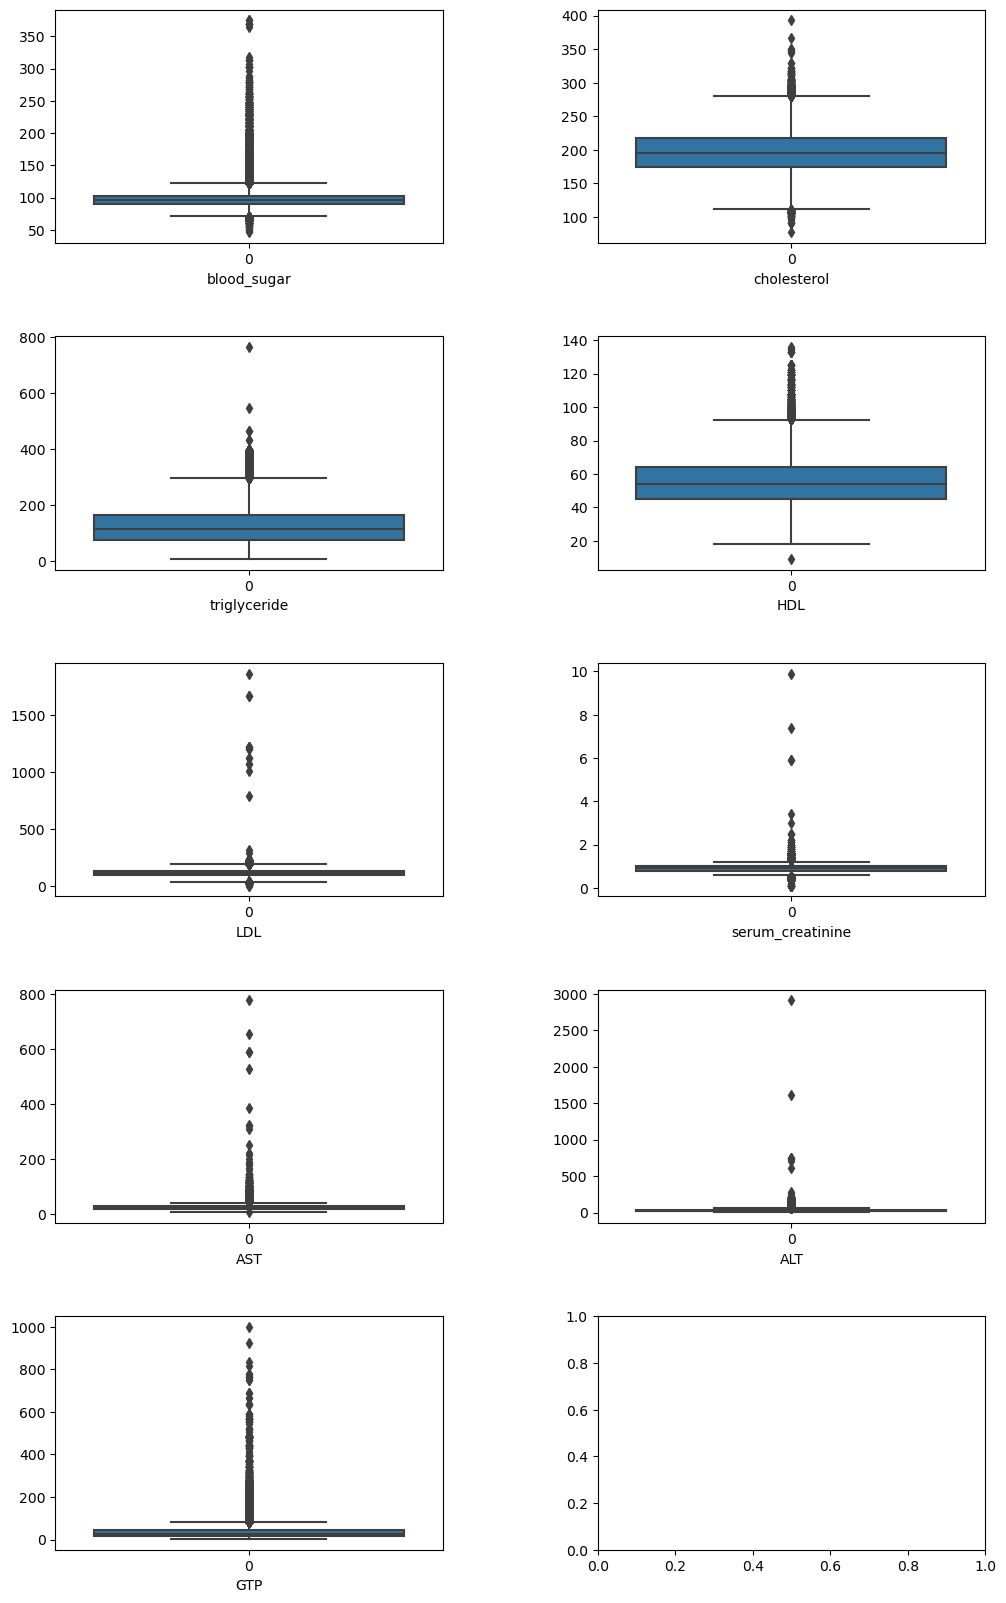

In [19]:
# plot the barplots of the features that need to be rid off outliers
fig, axs = plt.subplots(nrows=5, 
                        ncols=2, 
                        figsize=(12, 20))
for feature, ax in zip(outliers_values.keys(), axs.ravel()):
    sns.boxplot(data=train[feature], ax=ax)
    ax.set(ylabel='', xlabel=feature)
plt.subplots_adjust(wspace=.4, hspace=.4)

In [20]:
# count the number of rows with the outliers
train[train.blood_sugar > 300].shape[0]

20

In [21]:
# ...
train[train.cholesterol > 320].shape[0]

13

In [22]:
# ...
train[train.triglyceride > 400].shape[0]

6

In [23]:
# ...
train[train.HDL > 121].shape[0]

21

In [24]:
# ...
train[train.LDL > 500].shape[0]

14

In [25]:
# ...
train[train.serum_creatinine > 2].shape[0]

16

In [26]:
# ...
train[train.AST > 150].shape[0]

18

In [27]:
# ...
train[train.ALT > 250].shape[0]

8

In [28]:
# ...
train[train.GTP > 600].shape[0]

18

In [29]:
# set maximum values for the features
for feature, value in zip(outliers_values.keys(), [300, 320, 400, 121, 500, 2, 150, 250, 600]):
    outliers_values[feature] = value

In [30]:
def drop_outliers(df):
    """Func drops outliers"""
    for feature, value in outliers_values.items():
        df = df.drop(df[df[feature] > value].index)
    print('size of a dataframe after outliers dropping: {}'.format(df.shape[0]))
    df = df.reset_index(drop=True)
    return df

In [31]:
# evaluate clean df
evaluate_transformation(df=train.copy(), 
                        func=drop_outliers, 
                        label='outliers dropped')
log_df

size of a dataframe after outliers dropping: 159130


,label,train_score,test_score
0,initial df,0.801774,0.780065
1,outliers dropped,0.802388,0.777261


In [32]:
# apply outliers dropping
train = drop_outliers(train)

size of a dataframe after outliers dropping: 159130


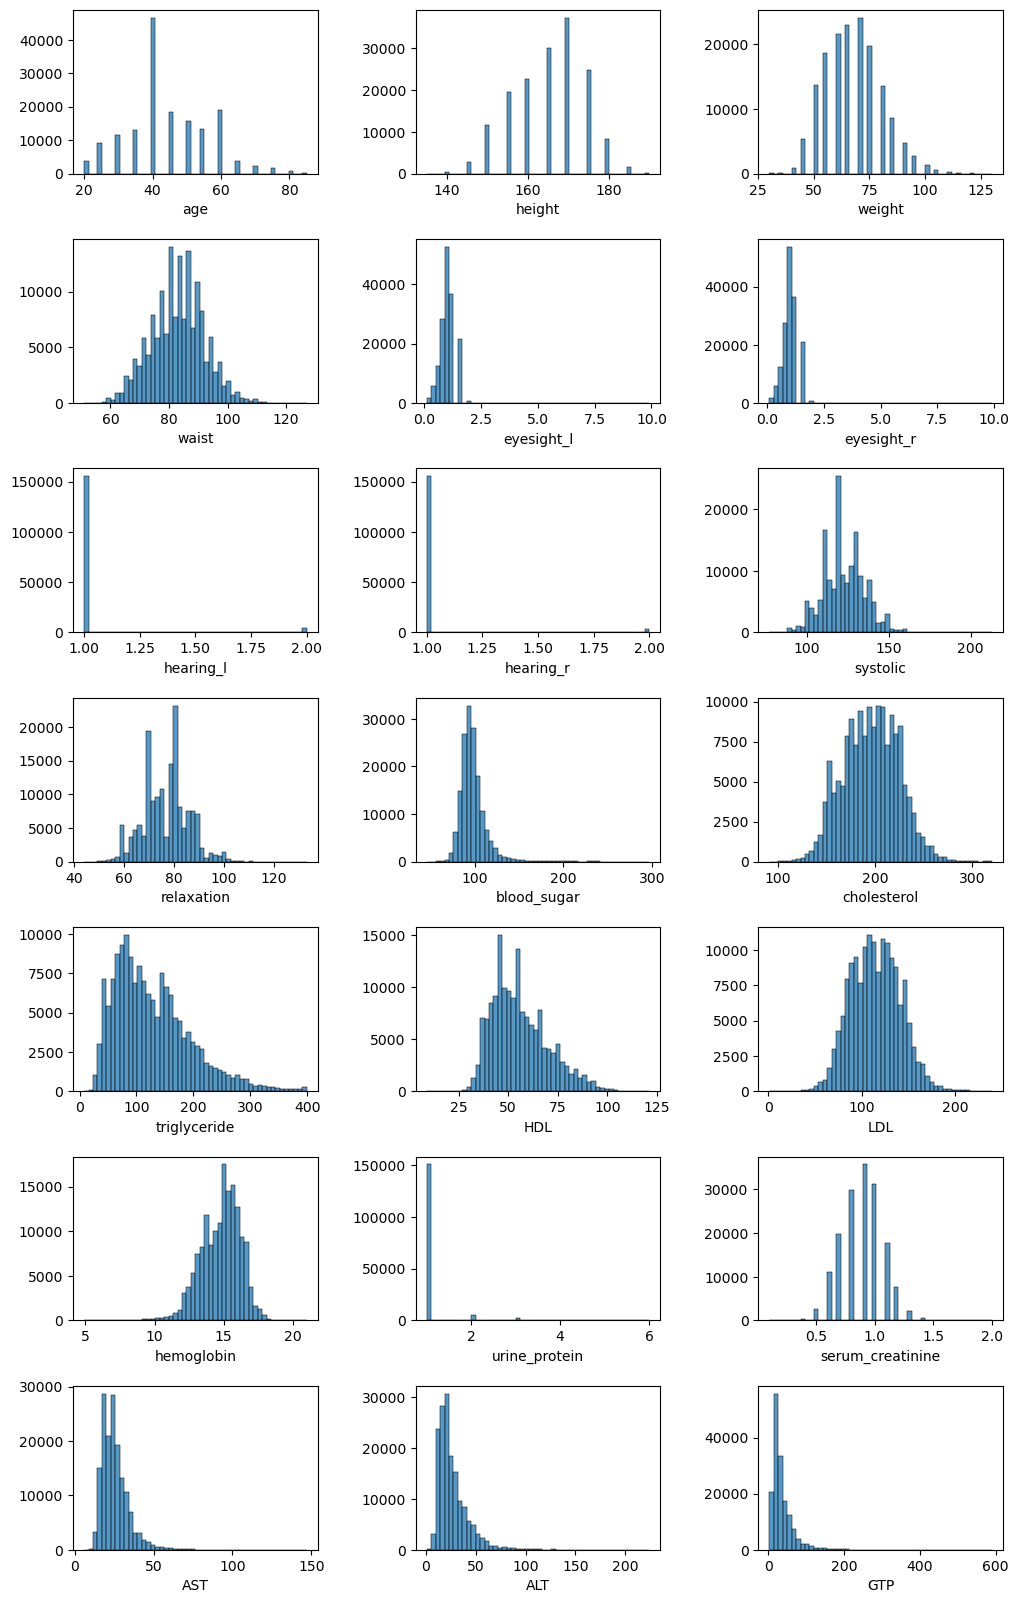

In [33]:
# plot distributions of each numeric feature after outliers dropping
fig, axs = plt.subplots(nrows=7, 
                        ncols=3, 
                        figsize=(12, 20))
for feature, ax in zip(numeric_features, axs.ravel()):
    sns.histplot(data=train, 
                 x=feature, 
                 ax=ax, 
                 bins=50)
    ax.set(ylabel='')
plt.subplots_adjust(wspace=.4, hspace=.4)

__!! RECALL__: call __drop_outliers()__ on a test dataframe.

___

### ADDING AND DROPPING FEATURES

In [34]:
# evaluate adding and dropping of different features

def add_different_eyesight(df):
    df['different_eyesight'] = (df.eyesight_l != df.eyesight_r).astype(int)
    return df

def add_different_hearing(df):
    df['different_hearing'] = (df.hearing_l != df.hearing_r).astype(int)
    return df

def drop_hearing_r(df):
    return df.drop('hearing_r', axis=1)

def add_pressure_difference(df):
    df['pressure_difference'] = abs(df.systolic - df.relaxation)
    return df

def drop_relaxation(df):
    return df.drop('relaxation', axis=1)

def drop_systolic(df):
    return df.drop('systolic', axis=1)

adding_and_deleting_features = {
    'add different_eyesight': add_different_eyesight,
    'add different_hearing': add_different_hearing,
    'add different_hearing and drop hearing_r': lambda df: drop_hearing_r(add_different_hearing(df)),
    'add pressure_difference': add_pressure_difference,
    'add pressure_difference and drop relaxation': lambda df: drop_relaxation(add_pressure_difference(df)),
    'add pressure_difference and drop systolic': lambda df: drop_systolic(add_pressure_difference(df)),
}

for label, func in adding_and_deleting_features.items():
    evaluate_transformation(df=train.copy(), 
                            func=func,
                            label=label)
    
log_df

,label,train_score,test_score
0,initial df,0.801774,0.780065
1,outliers dropped,0.802388,0.777261
2,add different_eyesight,0.801867,0.778976
3,add different_hearing,0.801843,0.777615
4,add different_hearing and drop hearing_r,0.801841,0.777859
5,add pressure_difference,0.802568,0.777635
6,add pressure_difference and drop relaxation,0.801974,0.778852
7,add pressure_difference and drop systolic,0.801791,0.778083


In [39]:
def add_and_drop_features(df):
    """Func adds and drops features"""
    # define the best combination (THE SEARCH HAD BEEN DETELED FROM THE SCRIPT)
    df = add_pressure_difference(df)
    df = drop_relaxation(df)
    return df

In [40]:
# evaluate feature engineering
train = add_and_drop_features(train)
evaluate_transformation(df=train.copy(), 
                        func=lambda df: df,
                        label='add and drop features')

log_df

,label,train_score,test_score
0,initial df,0.801774,0.780065
1,outliers dropped,0.802388,0.777261
2,add different_eyesight,0.801867,0.778976
3,add different_hearing,0.801843,0.777615
4,add different_hearing and drop hearing_r,0.801841,0.777859
5,add pressure_difference,0.802568,0.777635
6,add pressure_difference and drop relaxation,0.801974,0.778852
7,add pressure_difference and drop systolic,0.801791,0.778083
8,add and drop features,0.801974,0.778852


__!! RECALL__: call __add_and_drop_features()__ on a test dataframe.

___

### CLUSTERING

In [41]:
train.columns

Index(['age', 'height', 'weight', 'waist', 'eyesight_l', 'eyesight_r',
       'hearing_l', 'hearing_r', 'systolic', 'blood_sugar', 'cholesterol',
       'triglyceride', 'HDL', 'LDL', 'hemoglobin', 'urine_protein',
       'serum_creatinine', 'AST', 'ALT', 'GTP', 'dental_caries', 'smoking',
       'pressure_difference'],
      dtype='object')

In [42]:
# define the dict with clustering groups
clustering_groups = {
    'sex_gr': ['height', 'weight', 'waist'],
    'pressure_gr': ['systolic', 'pressure_difference'],
    'cholesterol_gr': ['cholesterol', 'triglyceride', 'HDL', 'LDL'],
    'blood_gr': ['blood_sugar', 'hemoglobin'],
    'kidneys_and_liver_gr': ['serum_creatinine', 'AST', 'ALT']
}

# estimate clustering with different groups and varying number of clusters
for label, features in clustering_groups.items():
    print('... calculating clustering for {}\n\t'.format(label), end='')
    for i in range(2, 8):
        print('*', end='')
        clusterizer = KMeans(n_clusters=i, 
                             n_init=10, 
                             random_state=1)
        clusterizer.fit(train[features])
        new_features = clusterizer.predict(train[features])
        evaluate_transformation(df=pd.concat([train, 
                                              pd.DataFrame({label: new_features})], 
                                             axis=1), 
                                func=lambda df: df,
                                label='add {} with {} clusters'.format(label, i))
    print('\tdone!\n')
log_df

... calculating clustering for sex_gr
	******	done!

... calculating clustering for pressure_gr
	******	done!

... calculating clustering for cholesterol_gr
	******	done!

... calculating clustering for blood_gr
	******	done!

... calculating clustering for kidneys_and_liver_gr
	******	done!



,label,train_score,test_score
0,initial df,0.801774,0.780065
1,outliers dropped,0.802388,0.777261
2,add different_eyesight,0.801867,0.778976
3,add different_hearing,0.801843,0.777615
4,add different_hearing and drop hearing_r,0.801841,0.777859
5,add pressure_difference,0.802568,0.777635
6,add pressure_difference and drop relaxation,0.801974,0.778852
7,add pressure_difference and drop systolic,0.801791,0.778083
8,add and drop features,0.801974,0.778852
9,add sex_gr with 2 clusters,0.801909,0.778235


In [43]:
# after analyzing the log_df, define the best clustering params (n_clusters)
best_clustering_params = {}
for group, value in zip(clustering_groups.keys(), [4, 2, 2, 5, 5]):
    best_clustering_params[group] = value

In [44]:
# fit clusterizers with the best params
best_clusterizers = {}
for group in clustering_groups:
    clusterizer = KMeans(n_clusters=best_clustering_params[group], 
                         n_init=10, r
                         andom_state=1)
    clusterizer.fit(train[clustering_groups[group]])
    best_clusterizers[group] = clusterizer

In [45]:
def apply_clusterizer(df, group):
    """Func applies clustering for a group"""
    new_features = best_clusterizers[group].predict(df[clustering_groups[group]])
    df = pd.concat([df, 
                    pd.DataFrame({group: new_features})], 
                   axis=1)
    return df

In [46]:
# evaluate the impact of clustering with different groups of features
for group in clustering_groups:
    evaluate_transformation(df=train.copy(), 
                            func=lambda df: apply_clusterizer(df, group),
                            label='add the best {} clustering'.format(group))
log_df

,label,train_score,test_score
0,initial df,0.801774,0.780065
1,outliers dropped,0.802388,0.777261
2,add different_eyesight,0.801867,0.778976
3,add different_hearing,0.801843,0.777615
4,add different_hearing and drop hearing_r,0.801841,0.777859
5,add pressure_difference,0.802568,0.777635
6,add pressure_difference and drop relaxation,0.801974,0.778852
7,add pressure_difference and drop systolic,0.801791,0.778083
8,add and drop features,0.801974,0.778852
9,add sex_gr with 2 clusters,0.801909,0.778235


In [51]:
def add_clustering(df):
    """Func applies optimal multiclustering"""
    # THE SEARCH IS OMITTED FROM THE SCRIPT
    df = apply_clusterizer(df, 'cholesterol_gr')
    df = apply_clusterizer(df, 'pressure_gr')
    df = apply_clusterizer(df, 'sex_gr')
    df = apply_clusterizer(df, 'blood_gr')
    df = apply_clusterizer(df, 'kidneys_and_liver_gr')
    return df

# evaluate multiclustering
evaluate_transformation(df=train.copy(), 
                        func=add_clustering,
                        label='add each *_gr')
log_df

,label,train_score,test_score
0,initial df,0.801774,0.780065
1,outliers dropped,0.802388,0.777261
2,add different_eyesight,0.801867,0.778976
3,add different_hearing,0.801843,0.777615
4,add different_hearing and drop hearing_r,0.801841,0.777859
5,add pressure_difference,0.802568,0.777635
6,add pressure_difference and drop relaxation,0.801974,0.778852
7,add pressure_difference and drop systolic,0.801791,0.778083
8,add and drop features,0.801974,0.778852
9,add sex_gr with 2 clusters,0.801909,0.778235


In [52]:
# apply multiclustering on a train set
train = add_clustering(train)

__!! RECALL__: call __add_clustering()__ on a test dataframe.

___

### NORM CATEGORIES FEATURES

In [57]:
train.columns

Index(['age', 'height', 'weight', 'waist', 'eyesight_l', 'eyesight_r',
       'hearing_l', 'hearing_r', 'systolic', 'blood_sugar', 'cholesterol',
       'triglyceride', 'HDL', 'LDL', 'hemoglobin', 'urine_protein',
       'serum_creatinine', 'AST', 'ALT', 'GTP', 'dental_caries', 'smoking',
       'pressure_difference', 'cholesterol_gr', 'pressure_gr', 'sex_gr',
       'blood_gr', 'kidneys_and_liver_gr'],
      dtype='object')

In [58]:
# define the names of the numeric features
numeric_features = [col for col in train.columns
                    if not ((train[col] == 0) | (train[col] == 1)).all()]
# describe these features
train[numeric_features].describe()

,age,height,weight,waist,eyesight_l,eyesight_r,hearing_l,hearing_r,systolic,blood_sugar,...,hemoglobin,urine_protein,serum_creatinine,AST,ALT,GTP,pressure_difference,sex_gr,blood_gr,kidneys_and_liver_gr
count,159130.000000,159130.000000,159130.000000,159130.000000,159130.000000,159130.000000,159130.000000,159130.000000,159130.000000,159130.000000,...,159130.000000,159130.000000,159130.000000,159130.000000,159130.000000,159130.000000,159130.000000,159130.000000,159130.000000,159130.000000
mean,44.304097,165.266669,67.143662,83.001577,1.005856,1.001064,1.023968,1.023402,122.499975,98.316672,...,14.797151,1.073971,0.892510,25.477685,26.489499,36.115987,45.628794,1.424075,1.286967,1.748721
std,11.840826,8.819524,12.584897,8.956630,0.402147,0.392333,0.152949,0.151178,12.727305,15.076898,...,1.430975,0.346780,0.175751,8.581569,15.190305,30.144534,8.393361,1.232223,0.941517,1.771996
min,20.000000,135.000000,30.000000,51.000000,0.100000,0.100000,1.000000,1.000000,77.000000,46.000000,...,4.900000,1.000000,0.100000,6.000000,1.000000,3.000000,0.000000,0.000000,0.000000,0.000000
25%,40.000000,160.000000,60.000000,77.000000,0.800000,0.800000,1.000000,1.000000,114.000000,90.000000,...,13.800000,1.000000,0.800000,20.000000,16.000000,18.000000,40.000000,0.000000,0.000000,0.000000
50%,40.000000,165.000000,65.000000,83.000000,1.000000,1.000000,1.000000,1.000000,121.000000,96.000000,...,15.000000,1.000000,0.900000,24.000000,22.000000,27.000000,45.000000,1.000000,2.000000,1.000000
75%,55.000000,170.000000,75.000000,89.000000,1.200000,1.200000,1.000000,1.000000,130.000000,103.000000,...,15.800000,1.000000,1.000000,29.000000,32.000000,44.000000,50.000000,3.000000,2.000000,4.000000
max,85.000000,190.000000,130.000000,127.000000,9.900000,9.900000,2.000000,2.000000,213.000000,297.000000,...,21.000000,6.000000,2.000000,147.000000,224.000000,590.000000,131.000000,3.000000,4.000000,4.000000


In [59]:
# define norms for features as a dict; the norm has a structure of list(min, max)
norms = {
    'systolic': [90, 120],
    'blood_sugar': [70, 130],
    'cholesterol': [125, 200],
    'triglyceride': [35, 150],
    'HDL': [35, 82],
    'LDL': [100, 129],
    'hemoglobin': [12.1, 17.2],
    'serum_creatinine': [0.5, 1.2],
    'AST': [5, 50],
    'ALT': [7, 50]
}

In [60]:
def add_norm_category(df, category):
    """Func adds a norm category"""
    df['{}_normal'.format(category)] = ((df[category] >= norms[category][0]) 
                                        & (df[category] <= norms[category][1])).astype(int)
    return df

In [61]:
# evaluate the impact of different norms adding
for category in norms:
    evaluate_transformation(df=train.copy(), 
                            func=lambda df: add_norm_category(df, category),
                            label='add {}_normal'.format(category))

In [62]:
log_df.tail(15)

,label,train_score,test_score
40,add the best pressure_gr clustering,0.801585,0.778366
41,add the best cholesterol_gr clustering,0.800924,0.778976
42,add the best blood_gr clustering,0.801513,0.778308
43,add the best kidneys_and_liver_gr clustering,0.801709,0.778472
44,add each *_gr,0.801969,0.778254
45,add systolic_normal,0.800358,0.778450
46,add blood_sugar_normal,0.802012,0.777116
47,add cholesterol_normal,0.800465,0.777356
48,add triglyceride_normal,0.800112,0.777529
49,add HDL_normal,0.800921,0.777191


In [63]:
def add_norm_categories(df):
    """Func adds all norms"""
    for category in norms:
        df = add_norm_category(df, category)
    return df
# evaluate the impact of all norms adding
evaluate_transformation(df=train.copy(), 
                        func=add_norm_categories,
                        label='add all *_normal')

In [64]:
log_df.tail(15)

,label,train_score,test_score
41,add the best cholesterol_gr clustering,0.800924,0.778976
42,add the best blood_gr clustering,0.801513,0.778308
43,add the best kidneys_and_liver_gr clustering,0.801709,0.778472
44,add each *_gr,0.801969,0.778254
45,add systolic_normal,0.800358,0.778450
46,add blood_sugar_normal,0.802012,0.777116
47,add cholesterol_normal,0.800465,0.777356
48,add triglyceride_normal,0.800112,0.777529
49,add HDL_normal,0.800921,0.777191
50,add LDL_normal,0.801296,0.778013


In [69]:
def add_norm_categories(df):
    """Func adds selected categories (optimal)"""
    # THE SEARCH IS OMITTED FROM THE SCRIPT
    for category in ['systolic', 'cholesterol', 'LDL']:
        df = add_norm_category(df, category)
    return df

# evaluate the norms adding
evaluate_transformation(df=train.copy(), 
                        func=add_norm_categories,
                        label='add systolic_normal, cholesterol_normal and LDL_normal')

log_df.tail(15)

,label,train_score,test_score
42,add the best blood_gr clustering,0.801513,0.778308
43,add the best kidneys_and_liver_gr clustering,0.801709,0.778472
44,add each *_gr,0.801969,0.778254
45,add systolic_normal,0.800358,0.778450
46,add blood_sugar_normal,0.802012,0.777116
47,add cholesterol_normal,0.800465,0.777356
48,add triglyceride_normal,0.800112,0.777529
49,add HDL_normal,0.800921,0.777191
50,add LDL_normal,0.801296,0.778013
51,add hemoglobin_normal,0.800663,0.776295


In [70]:
# apply transform
train = add_norm_categories(train)

__!! RECALL__: call __add_norm_categories()__ on a test dataframe.

___

### ALL FEATURE ENGINEERING

In [90]:
def apply_feature_engineering(df):
    """Func applies all feature engineering to a df"""
    df = rename_columns(df)
    df = add_and_drop_features(df)
    df = add_clustering(df)
    df = add_norm_categories(df)
    return df

__!! RECALL__: call __apply_feature_engineering()__ on a test dataframe.

___

### BASIC MODELS

In [128]:
train

,age,height,weight,waist,eyesight_l,eyesight_r,hearing_l,hearing_r,systolic,blood_sugar,...,smoking,pressure_difference,cholesterol_gr,pressure_gr,sex_gr,blood_gr,kidneys_and_liver_gr,systolic_normal,cholesterol_normal,LDL_normal
0,55,165,60,81.0,0.5,0.6,1,1,135,94,...,1,48,1,1,3,2,4,0,1,0
1,70,165,65,89.0,0.6,0.7,2,2,146,147,...,0,63,0,1,3,3,4,0,1,1
2,20,170,75,81.0,0.4,0.5,1,1,118,79,...,1,43,1,0,0,0,4,1,1,0
3,35,180,95,105.0,1.5,1.2,1,1,131,91,...,0,43,1,1,2,2,4,0,1,1
4,30,165,60,80.5,1.5,1.0,1,1,121,91,...,1,45,0,0,3,2,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
159125,40,155,45,69.0,1.5,2.0,1,1,127,64,...,0,47,0,1,1,0,4,0,0,0
159126,50,155,75,82.0,1.0,1.0,1,1,120,89,...,0,40,1,0,3,0,0,1,0,1
159127,40,160,50,66.0,1.5,1.0,1,1,114,84,...,0,44,0,0,1,0,0,1,1,0
159128,50,165,75,92.0,1.2,1.0,1,1,121,122,...,1,31,1,0,0,3,0,0,1,0


In [132]:
# initialize X_train, y_train
X_train = train.drop('smoking', axis=1)
y_train = train.smoking

In [151]:
# set a dict of models to analyze
models = {
    # logistic regression
    'logr': {
        'params': {
            'C': [100],
            'solver': ['newton-cholesky']
        },
        'template': lambda params: make_pipeline(FunctionTransformer(func=np.log1p),
                                                 PolynomialFeatures(degree=2, 
                                                                    include_bias=False),
                                                 StandardScaler(),
                                                 LogisticRegression(**params, 
                                                                    random_state=1, 
                                                                    max_iter=1500))
    },
    
    # hist GB classifier
    'hgb': {
        'params': {
            'max_depth': [10],
            'min_samples_leaf': [25],
            'l2_regularization': [10]
        },
        'template': lambda params: HistGradientBoostingClassifier(**params, 
                                                                  random_state=1)
    },
    
    # XGBoost classifier
    'xgb': {
        'params': {
            'n_estimators': [2000],
            'max_depth': [2],
            'objective': ['reg:squarederror']
        },
        'template': lambda params: XGBClassifier(**params, 
                                                 random_state=1)
    },
    
    # AdaBoost classifier
    'ada': {
        'params': {
            'n_estimators': [50],
            'estimator': [DecisionTreeClassifier(max_depth=3, 
                                                 random_state=1)]
        },
        'template': lambda params: make_pipeline(FunctionTransformer(func=np.log1p),
                                                 PolynomialFeatures(degree=2, 
                                                                    include_bias=False),
                                                 StandardScaler(),
                                                 AdaBoostClassifier(**params, 
                                                                    random_state=1))
    },
    
    # light GB classifier
    'lgb': {
        'params': {
            'objective': ['binary'],
            'metric': ['auc'],
            'n_estimators': [300, 600, 900, 2000],
            'max_depth': [2, 3, 4, 5, 6, 7, 8]
        },
        'template': lambda params: LGBMClassifier(**params, 
                                                  verbose=-1, 
                                                  random_state=1)
        
    },
    
    # cat boost classifier
    'cat': {
        'params': {
            'depth': [6],
            'eval_metric': ['AUC'],
            
        },
        'template': lambda params: CatBoostClassifier(**params, 
                                                      silent=True, 
                                                      random_state=1)
    },
    
}

In [152]:
def all_combinations(params):
    """A func returns a list of all combinations of input parameters"""
    keys = list(params)
    combinations = []
    for values in itertools.product(*map(params.get, list(params))):
        combinations.append(dict(zip(keys, values)))
    return combinations

In [153]:
def cv(model):
    """A func cross-validates input model and returns an auc-score"""
    splitter = StratifiedKFold(n_splits=10, 
                               shuffle=True, 
                               random_state=1)
    auc_list = []
    for train_indexlist, validate_indexlist in splitter.split(X_train, y_train):
        X_t = train.iloc[train_indexlist]
        X_v = train.iloc[validate_indexlist]
        y_t = X_t.pop('smoking')
        y_v = X_v.pop('smoking')
        model.fit(X_t, y_t)
        try:
            y_pred = model.predict_proba(X_v)[:, 1]
        except AttributeError:
            y_pred = model.decision_function(X_v)
        auc_list.append(roc_auc_score(y_v, y_pred))
    auc = np.array(auc_list).mean()
    return auc

In [154]:
# create a dict to store the scores and parameters of the best models
best_models = {}
# for each model find the best score and parameters (e.g. fill best_models dict)
for modelname, data in models.items():
    best_score = 0
    best_params = {}
    for params in all_combinations(data['params']):
        model = data['template'](params)
        print('~ cross-validating {} model\n  with params {}\n\t...'.format(modelname, params))
        score = cv(model)
        print('\tdone! auc-score: {0:.4f}\n'.format(score))
        if score > best_score:
            best_score = score
            best_params = params
    best_models[modelname] = {
        'params': best_params,
        'score': best_score
    }

~ cross-validating logr model
  with params {'C': 100, 'solver': 'newton-cholesky'}
	...
	done! auc-score: 0.8552

~ cross-validating hgb model
  with params {'max_depth': 10, 'min_samples_leaf': 25, 'l2_regularization': 10}
	...
	done! auc-score: 0.8649

~ cross-validating xgb model
  with params {'n_estimators': 2000, 'max_depth': 2, 'objective': 'reg:squarederror'}
	...
	done! auc-score: 0.8684

~ cross-validating ada model
  with params {'n_estimators': 50, 'estimator': DecisionTreeClassifier(max_depth=3, random_state=1)}
	...
	done! auc-score: 0.8528

~ cross-validating lgb model
  with params {'objective': 'binary', 'metric': 'auc', 'n_estimators': 300, 'max_depth': 2}
	...
	done! auc-score: 0.8610

~ cross-validating lgb model
  with params {'objective': 'binary', 'metric': 'auc', 'n_estimators': 300, 'max_depth': 3}
	...
	done! auc-score: 0.8641

~ cross-validating lgb model
  with params {'objective': 'binary', 'metric': 'auc', 'n_estimators': 300, 'max_depth': 4}
	...
	done! 

In [155]:
# print the content of best_models dict
for modelname in best_models:
    print('The best {} model:\n\tscore: {}\n\tparams: {}\n'.format(modelname, 
                                                                   best_models[modelname]['score'], 
                                                                   best_models[modelname]['params']))

The best logr model:
	score: 0.85520881614523
	params: {'C': 100, 'solver': 'newton-cholesky'}

The best hgb model:
	score: 0.8648606514600715
	params: {'max_depth': 10, 'min_samples_leaf': 25, 'l2_regularization': 10}

The best xgb model:
	score: 0.8684349804896648
	params: {'n_estimators': 2000, 'max_depth': 2, 'objective': 'reg:squarederror'}

The best ada model:
	score: 0.8528372816174199
	params: {'n_estimators': 50, 'estimator': DecisionTreeClassifier(max_depth=3, random_state=1)}

The best lgb model:
	score: 0.8701430211055993
	params: {'objective': 'binary', 'metric': 'auc', 'n_estimators': 2000, 'max_depth': 3}

The best cat model:
	score: 0.8686460998260694
	params: {'depth': 6, 'eval_metric': 'AUC'}



In [156]:
# create a dataframe with the best models' scores
best_models_df = pd.DataFrame()
for modelname, data in best_models.items():
    row = pd.DataFrame({'label': [modelname], 
                        'score': [data['score']]})
    best_models_df = pd.concat([best_models_df, row], 
                               ignore_index=True)
best_models_df = best_models_df.sort_values(by='score', ascending=False).reset_index(drop=True)
best_models_df

,label,score
0,lgb,0.870143
1,cat,0.868646
2,xgb,0.868435
3,hgb,0.864861
4,logr,0.855209
5,ada,0.852837


___

### ENSEMBLES

In [160]:
best_models_labels_dict = {
    'tree_models': ['hgb', 'cat', 'lgb', 'xgb'],
    'nontree_models': ['logr']
}

In [161]:
# define all possible combinations of models for ensembles. 
# the main rule is that every ensemble has to include one non-tree model
ensemble_combinations = []
for item in itertools.combinations(best_models_labels_dict['tree_models'], 2):
    for nontree_item in best_models_labels_dict['nontree_models']:
        ensemble_combinations.append(list(itertools.chain(item)) + [nontree_item])
ensemble_combinations

[['hgb', 'cat', 'logr'],
 ['hgb', 'lgb', 'logr'],
 ['hgb', 'xgb', 'logr'],
 ['cat', 'lgb', 'logr'],
 ['cat', 'xgb', 'logr'],
 ['lgb', 'xgb', 'logr']]

In [162]:
# create a dict to store the scores and models of the ensembles
ensembles = {}
# for each ensemble find the best score and structure (e.g. fill ensembles dict)
for combination in ensemble_combinations:
    ensemble = [(label, models[label]['template'](best_models[label]['params'])) for label in combination]
    modelname = 'ens({} + {} + {})'.format(*[label for label in combination])
    model = VotingClassifier(ensemble, voting='soft')
    print('~ cross-validating {} model\n\t...'.format(modelname))
    score = cv(model)
    print('\tdone! auc-score: {0:.4f}\n'.format(score))
    ensembles[modelname] = {
        'score': score,
        'model': model
    }

~ cross-validating ens(hgb + cat + logr) model
	...
	done! auc-score: 0.8662

~ cross-validating ens(hgb + lgb + logr) model
	...
	done! auc-score: 0.8674

~ cross-validating ens(hgb + xgb + logr) model
	...
	done! auc-score: 0.8670

~ cross-validating ens(cat + lgb + logr) model
	...
	done! auc-score: 0.8685

~ cross-validating ens(cat + xgb + logr) model
	...
	done! auc-score: 0.8681

~ cross-validating ens(lgb + xgb + logr) model
	...
	done! auc-score: 0.8689



In [163]:
# create a dataframe with scores of the ensembles
ensembles_df = pd.DataFrame()
for modelname, data in ensembles.items():
    row = pd.DataFrame({'label': [modelname], 
                        'score': [data['score']]})
    ensembles_df = pd.concat([ensembles_df, row], 
                             ignore_index=True)
ensembles_df = ensembles_df.sort_values(by='score', ascending=False).reset_index(drop=True)
ensembles_df

,label,score
0,ens(lgb + xgb + logr),0.868907
1,ens(cat + lgb + logr),0.868500
2,ens(cat + xgb + logr),0.868101
3,ens(hgb + lgb + logr),0.867437
4,ens(hgb + xgb + logr),0.866988
5,ens(hgb + cat + logr),0.866229


In [165]:
# define all possible combinations of models for ensembles, that has lgb model and one another model
ensemble_combinations_2 = [['lgb', 'cat'],
                           ['lgb', 'xgb'],
                           ['lgb', 'hgb'],
                           ['lgb', 'logr']]

In [166]:
# create a dict to store the scores and models of the ensembles 2
ensembles_2 = {}
# for each ensemble find the best score and structure (e.g. fill ensembles dict)
for combination in ensemble_combinations_2:
    ensemble = [(label, models[label]['template'](best_models[label]['params'])) for label in combination]
    modelname = 'ens({} + {})'.format(*[label for label in combination])
    model = VotingClassifier(ensemble, voting='soft')
    print('~ cross-validating {} model\n\t...'.format(modelname))
    score = cv(model)
    print('\tdone! auc-score: {0:.4f}\n'.format(score))
    ensembles_2[modelname] = {
        'score': score,
        'model': model
    }

~ cross-validating ens(lgb + cat) model
	...
	done! auc-score: 0.8704

~ cross-validating ens(lgb + xgb) model
	...
	done! auc-score: 0.8704

~ cross-validating ens(lgb + hgb) model
	...
	done! auc-score: 0.8694

~ cross-validating ens(lgb + logr) model
	...
	done! auc-score: 0.8670



In [167]:
# create a dataframe with scores of the ensembles 2
ensembles_df_2 = pd.DataFrame()
for modelname, data in ensembles_2.items():
    row = pd.DataFrame({'label': [modelname], 
                        'score': [data['score']]})
    ensembles_df_2 = pd.concat([ensembles_df_2, row], 
                               ignore_index=True)
ensembles_df_2 = ensembles_df_2.sort_values(by='score', ascending=False).reset_index(drop=True)
ensembles_df_2

,label,score
0,ens(lgb + cat),0.870439
1,ens(lgb + xgb),0.870377
2,ens(lgb + hgb),0.869435
3,ens(lgb + logr),0.867004


In [168]:
# will try to look at an ensemble consisting of lgb, cat and xgb models
ensemble_combinations_3 = [['lgb', 'cat', 'xgb']]
ensembles_3 = {}
# for each ensemble find the best score and structure (e.g. fill ensembles dict)
for combination in ensemble_combinations_3:
    ensemble = [(label, models[label]['template'](best_models[label]['params'])) for label in combination]
    modelname = 'ens({} + {} + {})'.format(*[label for label in combination])
    model = VotingClassifier(ensemble, voting='soft')
    print('~ cross-validating {} model\n\t...'.format(modelname))
    score = cv(model)
    print('\tdone! auc-score: {0:.4f}\n'.format(score))
    ensembles_3[modelname] = {
        'score': score,
        'model': model
    }

~ cross-validating ens(lgb + cat + xgb) model
	...
	done! auc-score: 0.8706



In [169]:
# create a dataframe with scores of the ensembles 3
ensembles_df_3 = pd.DataFrame()
for modelname, data in ensembles_3.items():
    row = pd.DataFrame({'label': [modelname], 
                        'score': [data['score']]})
    ensembles_df_3 = pd.concat([ensembles_df_3, row], 
                               ignore_index=True)
ensembles_df_3 = ensembles_df_3.sort_values(by='score', ascending=False).reset_index(drop=True)
ensembles_df_3

,label,score
0,ens(lgb + cat + xgb),0.870639


In [170]:
# concat three dataframes in one df
display(pd.concat([ensembles_df, 
                   ensembles_df_2, 
                   ensembles_df_3], 
                  ignore_index=True))
ensembles_df = pd.concat([ensembles_df, 
                          ensembles_df_2, 
                          ensembles_df_3], 
                         ignore_index=True)

,label,score
0,ens(lgb + xgb + logr),0.868907
1,ens(cat + lgb + logr),0.868500
2,ens(cat + xgb + logr),0.868101
3,ens(hgb + lgb + logr),0.867437
4,ens(hgb + xgb + logr),0.866988
5,ens(hgb + cat + logr),0.866229
6,ens(lgb + cat),0.870439
7,ens(lgb + xgb),0.870377
8,ens(lgb + hgb),0.869435
9,ens(lgb + logr),0.867004


In [187]:
# will try to look at the ensemble consisting of four tree models
ensemble_combinations_4 = [['lgb', 'cat', 'xgb', 'ada']]
# create a dict to store the scores and models of the ensembles 4
ensembles_4 = {}
# for each ensemble find the best score and structure (e.g. fill ensembles dict)
for combination in ensemble_combinations_4:
    ensemble = [(label, models[label]['template'](best_models[label]['params'])) for label in combination]
    modelname = 'ens({} + {} + {} + {})'.format(*[label for label in combination])
    model = VotingClassifier(ensemble, voting='soft')
    print('~ cross-validating {} model\n\t...'.format(modelname))
    score = cv(model)
    print('\tdone! auc-score: {0:.4f}\n'.format(score))
    ensembles_4[modelname] = {
        'score': score,
        'model': model
    }
    
# create a dataframe with scores of the ensembles 4
ensembles_df_4 = pd.DataFrame()
for modelname, data in ensembles_4.items():
    row = pd.DataFrame({'label': [modelname], 
                        'score': [data['score']]})
    ensembles_df_4 = pd.concat([ensembles_df_4, row], 
                               ignore_index=True)
ensembles_df_4 = ensembles_df_4.sort_values(by='score', ascending=False).reset_index(drop=True)
ensembles_df_4

~ cross-validating ens(lgb + cat + xgb + ada) model
	...
	done! auc-score: 0.8707



,label,score
0,ens(lgb + cat + xgb + ada),0.870656


In [189]:
# concat everything into one df
ensembles_df = pd.concat([ensembles_df, ensembles_df_4], 
                         ignore_index=True)

___

### RESULTS

In [190]:
# concat and sort two dataframes that include scores for the best models and ensembles
resulting_df = pd.concat([best_models_df, ensembles_df], 
                         ignore_index=True) \
    .sort_values(by='score', ascending=False) \
    .reset_index(drop=True)
resulting_df

,label,score
0,ens(lgb + cat + xgb + ada),0.870656
1,ens(lgb + cat + xgb),0.870639
2,ens(lgb + cat),0.870439
3,ens(lgb + xgb),0.870377
4,lgb,0.870143
5,ens(lgb + hgb),0.869435
6,ens(lgb + xgb + logr),0.868907
7,cat,0.868646
8,ens(cat + lgb + logr),0.868500
9,xgb,0.868435


(0.8518372816174199, 0.8716560968679755)

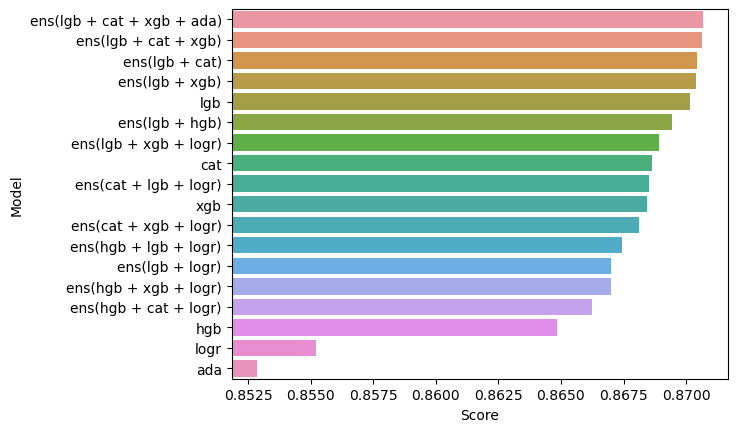

In [191]:
# make a barplot to illustrate the scores of models and ensembles
fig = sns.barplot(resulting_df, 
                  x='score', 
                  y='label')
fig.set(xlabel ='Score', ylabel = 'Model')
fig.set_xlim(resulting_df.score.min() - 0.001, 
             resulting_df.score.max() + 0.001) 

In [192]:
# get label of the best model
best_model_label = list(resulting_df.loc[resulting_df.score == resulting_df.score.max()].label)[0]
best_model_label

'ens(lgb + cat + xgb + ada)'

In [193]:
best_model = ensembles_4[best_model_label]['model']
best_model.fit(X_train, y_train)

VotingClassifier(estimators=[('lgb',
                              LGBMClassifier(max_depth=3, metric='auc',
                                             n_estimators=2000,
                                             objective='binary', random_state=1,
                                             verbose=-1)),
                             ('cat',
                              <catboost.core.CatBoostClassifier object at 0x000001D102E2D750>),
                             ('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None,
                                            early_st...
                                            objective='reg:squarederror',
                                            predictor=None, ...)),
                             ('ada',
                              Pipeline(steps=[('functiontransformer',
                                               FunctionTransformer(func=<ufunc 'log1p'>)),
                                              ('polynomialfeatures',
                                               PolynomialFeatures(include_bias=False)),
                                              ('standardscaler',
                                               StandardScaler()),
                                              ('adaboostclassifier',
                                               AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=3,
                                                                                                   random_state=1),
                                                                  random_state=1))]))],
                 voting='soft')

___

### SUBMISSION

In [194]:
# read the test set
test = pd.read_csv('test.csv', index_col='id').reset_index()
test

,id,age,height(cm),weight(kg),waist(cm),eyesight(left),eyesight(right),hearing(left),hearing(right),systolic,...,triglyceride,HDL,LDL,hemoglobin,Urine protein,serum creatinine,AST,ALT,Gtp,dental caries
0,159256,40,165,70,84.0,1.2,1.2,1,1,130,...,186,49,115,14.2,1,0.9,19,25,32,0
1,159257,80,160,60,93.0,1.0,1.0,2,2,144,...,158,35,104,13.0,1,1.1,20,12,24,0
2,159258,60,170,70,86.5,0.6,0.7,1,1,117,...,173,39,88,15.4,1,1.4,38,60,36,0
3,159259,40,160,50,67.0,0.3,0.4,1,1,116,...,47,75,128,14.5,1,0.6,25,18,10,1
4,159260,40,170,75,89.4,1.0,0.9,1,1,132,...,100,39,123,16.5,1,1.0,30,39,27,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
106166,265422,40,165,60,78.0,0.8,0.9,1,1,112,...,82,59,149,16.4,1,1.1,24,31,28,0
106167,265423,40,170,85,95.0,1.2,1.2,1,1,130,...,186,44,100,16.0,2,1.0,25,31,38,0
106168,265424,35,170,85,89.0,1.2,1.2,1,1,131,...,76,53,142,15.9,1,0.8,33,32,24,1
106169,265425,40,160,60,67.0,0.7,0.8,1,1,120,...,81,55,103,13.9,1,0.6,42,36,32,0


In [195]:
id_column = test.id
id_column

0         159256
1         159257
2         159258
3         159259
4         159260
           ...  
106166    265422
106167    265423
106168    265424
106169    265425
106170    265426
Name: id, Length: 106171, dtype: int64

In [198]:
test.drop('id', axis=1, inplace=True)
test = apply_feature_engineering(test)
test

,age,height,weight,waist,eyesight_l,eyesight_r,hearing_l,hearing_r,systolic,blood_sugar,...,dental_caries,pressure_difference,cholesterol_gr,pressure_gr,sex_gr,blood_gr,kidneys_and_liver_gr,systolic_normal,cholesterol_normal,LDL_normal
0,40,165,70,84.0,1.2,1.2,1,1,130,107,...,0,41,1,1,0,1,4,0,1,1
1,80,160,60,93.0,1.0,1.0,2,2,144,93,...,0,72,1,1,3,2,0,0,1,1
2,60,170,70,86.5,0.6,0.7,1,1,117,92,...,0,42,1,0,0,2,3,1,1,0
3,40,160,50,67.0,0.3,0.4,1,1,116,91,...,1,54,0,0,1,2,0,1,0,1
4,40,170,75,89.4,1.0,0.9,1,1,132,79,...,1,38,0,1,0,0,1,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
106166,40,165,60,78.0,0.8,0.9,1,1,112,134,...,0,34,0,0,3,3,4,1,0,0
106167,40,170,85,95.0,1.2,1.2,1,1,130,97,...,0,40,1,1,2,2,4,0,1,1
106168,35,170,85,89.0,1.2,1.2,1,1,131,106,...,1,45,0,1,2,1,1,0,0,0
106169,40,160,60,67.0,0.7,0.8,1,1,120,92,...,0,40,0,0,1,2,1,1,1,1


In [199]:
# make predictions and store them in a proper format
predictions = best_model.predict_proba(test)[:, 1]

In [200]:
predictions

array([0.53441982, 0.375495  , 0.34548919, ..., 0.43105548, 0.19856069,
       0.14280568])

In [201]:
submission = pd.DataFrame({'id': id_column, 
                           'smoking': predictions}).set_index('id')
submission.to_csv('submission_3.csv')

___